# **Курсовой проект на тему:**
## "Конвертер аудио лекций в текст с терминами"

### **Выполнили:**
#### Розов Станислав Александрович, ИДБ-22-13
#### Александров Сергей Викторович, ИДБ-22-13

Описание: 
*Сервис, который сможет создавать на основе аудиозаписи лекций
транскрибированный текст, выбирая в тексте сложные термины записывая их в
глоссарий.*

### Импорт библиотек:
###### Назначение: Импорт необходимых модулей для работы с файлами, аудио, GUI и распознавания речи
- vosk - ядро системы распознавания речи (на основе Kaldi)
- pydub - обработка аудиофайлов
- tkinter - графический интерфейс для выбора файлов

In [1]:
import os
import json
import wave
import warnings
from vosk import Model, KaldiRecognizer
from pydub import AudioSegment
import tkinter as tk
from tkinter import filedialog, messagebox, simpledialog

### Функции работы с файловой системой
- Создание диалоговых окон для выбора файлов/папок
- withdraw() скрывает главное окно Tkinter
- Возвращает абсолютные пути к выбранным объектам

In [2]:
def select_file(title="Выберите файл"):
    root = tk.Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(title=title)
    return file_path if file_path else None

def select_directory(title="Выберите папку для сохранения"):
    root = tk.Tk()
    root.withdraw()
    dir_path = filedialog.askdirectory(title=title)
    return dir_path if dir_path else None

def get_filename(default_name):
    root = tk.Tk()
    root.withdraw()
    filename = simpledialog.askstring("Имя файла", "Введите имя для сохранения файла:", initialvalue=default_name)
    return filename if filename else None



### Обработка аудио/видео файлов
Автоматическая обработка видеофайлов (извлечение звуковой дорожки)

##### Конвертация любых входных форматов в WAV с параметрами:
- Моно (1 канал)
- Частота 16 кГц
- 16-битная глубина звука
##### Единый формат аудио гарантирует совместимость с моделью распознавания речи и улучшает качество транскрибации.

In [3]:
def extract_audio_from_video(video_path, audio_output_path="temp_audio.wav"):
    try:
        video = AudioSegment.from_file(video_path)
        audio = video.set_channels(1).set_frame_rate(16000).set_sample_width(2)
        audio.export(audio_output_path, format="wav")
        return audio_output_path
    except Exception as e:
        messagebox.showerror("Ошибка", f"Ошибка извлечения аудио из видео: {e}")
        return None

def convert_to_wav(input_path):
    try:
        output_path = "temp_converted.wav"
        audio = AudioSegment.from_file(input_path)
        audio = audio.set_channels(1).set_frame_rate(16000).set_sample_width(2)
        audio.export(output_path, format="wav")
        return output_path
    except Exception as e:
        messagebox.showerror("Ошибка", f"Ошибка конвертации в WAV: {e}")
        return None



### Ядро распознавания речи
- Пошаговая обработка аудиопотока блоками по 4000 фреймов
- Накопление промежуточных результатов распознавания
- Финализация и сохранение полного текста
- Автоматическая очистка временных файлов

##### Алгоритм обеспечивает эффективную обработку больших файлов за счет потокового чтения и интеллектуальной обработки частичных результатов.

In [4]:
def recognize_audio(input_path, output_path, model_path, ffmpeg_path):
    os.environ["PATH"] += os.pathsep + ffmpeg_path
    AudioSegment.ffmpeg = os.path.join(ffmpeg_path, "ffmpeg.exe")
    AudioSegment.ffprobe = os.path.join(ffmpeg_path, "ffprobe.exe")

    warnings.filterwarnings("ignore", category=RuntimeWarning)

    if not os.path.exists(model_path):
        messagebox.showerror("Ошибка", "Модель не найдена. Скачайте с https://alphacephei.com/vosk/models")
        return

    if not os.path.exists(input_path):
        messagebox.showerror("Ошибка", "Входной файл не найден!")
        return

    input_lower = input_path.lower()
    delete_temp = False
    
    if input_lower.endswith(('.mp4', '.avi', '.mov', '.mkv', '.flv', '.wmv')):
        input_path = extract_audio_from_video(input_path)
        if not input_path: return
        delete_temp = True
    elif input_lower.endswith('.mp3') or not input_lower.endswith('.wav'):
        input_path = convert_to_wav(input_path)
        if not input_path: return
        delete_temp = True

    try:
        wf = wave.open(input_path, "rb")
    except Exception as e:
        messagebox.showerror("Ошибка", f"Ошибка открытия WAV файла: {e}")
        return

    if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getframerate() not in [8000, 16000]:
        wf.close()
        input_path = convert_to_wav(input_path)
        if not input_path: return
        try:
            wf = wave.open(input_path, "rb")
        except Exception as e:
            messagebox.showerror("Ошибка", f"Ошибка открытия конвертированного файла: {e}")
            return
        delete_temp = True

    model = Model(model_path)
    recognizer = KaldiRecognizer(model, wf.getframerate())
    full_text = []

    try:
        with open(output_path, "w", encoding="utf-8") as output_file:
            while True:
                data = wf.readframes(4000)
                if len(data) == 0: break
                if recognizer.AcceptWaveform(data):
                    result = json.loads(recognizer.Result())
                    if result.get("text", "").strip():
                        text_line = result["text"]
                        output_file.write(text_line + "\n")
                        full_text.append(text_line)
                        print(f"Распознано: {text_line}")

            final_result = json.loads(recognizer.FinalResult())
            if final_result.get("text", "").strip():
                final_text = final_result["text"]
                output_file.write(final_text + "\n")
                full_text.append(final_text)
                print(f"Финальный результат: {final_text}")
                
        print("\nПолный текст, который будет сохранен в файле:")
        print("-" * 50)
        for line in full_text:
            print(line)
        print("-" * 50)
        
        messagebox.showinfo("Готово", f"Текст сохранен в:\n{output_path}")
    except Exception as e:
        messagebox.showerror("Ошибка", f"Ошибка при сохранении: {e}")
    finally:
        wf.close()
        if delete_temp:
            try: os.remove(input_path)
            except: pass

if __name__ == "__main__":
    ffmpeg_path = r"C:\Users\1\AppData\Local\Programs\FFmpeg\bin"
    model_path = r"C:\Users\1\pop\vosk-model-ru-0.42"
    
    input_file = select_file("Выберите видео или аудио файл")
    if not input_file: exit()
    
    output_dir = select_directory("Выберите папку для сохранения")
    if not output_dir: exit()
    
    default_name = os.path.splitext(os.path.basename(input_file))[0] + "_transcription.txt"
    output_name = get_filename(default_name)
    if not output_name: exit()
    
    if not output_name.lower().endswith('.txt'):
        output_name += ".txt"
    
    output_file = os.path.join(output_dir, output_name)
    
    recognize_audio(input_file, output_file, model_path, ffmpeg_path)


Распознано: есть знаковые продукты в истории человечества
Распознано: шоколад и кофе и конечно же кофе наверное даже в первую очередь к таковым относятся вот
Распознано: потому что в общем-то это действительно во многом продукт который изменил очень многое изменил скажем так наши какие-то поведенческие паттерны в том числе мы же теперь идём попить кофе да мыши
Распознано: вот мы же не говорим а чай брейк мы говорим кофе брейк да мы говорим там а не пойти ли нам попить кофейку учёта чайку попить гораздо менее распространено заметили наверное да
Распознано: долой культуртрегерский напиток но вот как мы вообще без него жили совершенно непонятно но
Распознано: кстати говоря
Распознано: можно вообще в целом наверное регионы мира разделить на клубу культуры чайный и культур кофейные да даже так
Распознано: возможно вот и я вам так скажу что вот по этой шкале
Распознано: разделение на чайные и кофейные культуры на культуры с кофе на культуре без кофе вот наша с вами страна она
Распознано: чер

### Оценка качества распознавания

##### Наглядная визуализация результатов

##### Комплексная оценка точности через:
- WER (ошибки на уровне слов)
- CER (ошибки на уровне символов)
- Косинусная близость векторных представлений (семантическая схожесть)
##### Многоуровневая система оценки позволяет анализировать как поверхностные ошибки, так и смысловые искажения текста.

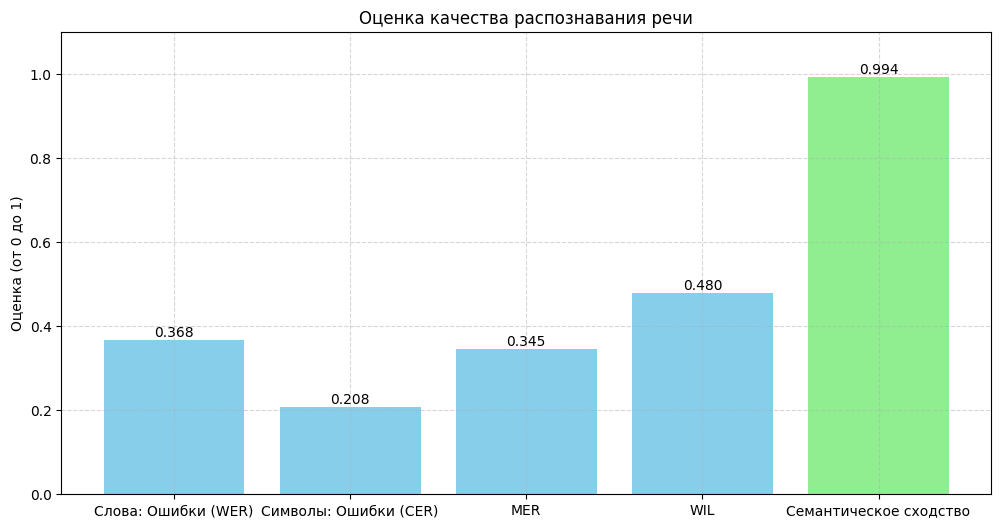

In [5]:
import matplotlib.pyplot as plt
from jiwer import wer, mer, wil, cer
import chardet
from sentence_transformers import SentenceTransformer, util
import numpy as np

def convert_to_utf8(file_path):
    try:
        with open(file_path, 'rb') as f:
            raw_data = f.read()
            encoding = chardet.detect(raw_data)['encoding']
        
        if not encoding:
            encoding = 'utf-8'
        
        with open(file_path, 'r', encoding=encoding, errors='replace') as f:
            content = f.read()
        
        if encoding.lower() == 'utf-8':
            return content
        
        with open(file_path, 'w', encoding='utf-8') as f:
            f.write(content)
            
        return content
    except Exception as e:
        raise Exception(f"Ошибка конвертации файла {file_path} в UTF-8: {str(e)}")

def load_text(file_path):
    try:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read().strip().lower()
                if not content:
                    raise ValueError(f"Файл {file_path} пустой")
                return content
        except UnicodeDecodeError:
            content = convert_to_utf8(file_path).strip().lower()
            if not content:
                raise ValueError(f"Файл {file_path} пустой после конвертации")
            return content
    except FileNotFoundError:
        raise FileNotFoundError(f"Файл {file_path} не найден")
    except Exception as e:
        raise Exception(f"Ошибка чтения файла {file_path}: {str(e)}")

def calculate_semantic_similarity(reference, hypothesis, model):
    ref_embedding = model.encode(reference, convert_to_tensor=True)
    hyp_embedding = model.encode(hypothesis, convert_to_tensor=True)
    cosine_sim = util.pytorch_cos_sim(ref_embedding, hyp_embedding).item()
    return cosine_sim

def evaluate_and_plot(reference_file, hypothesis_file):
    try:
        reference = load_text(reference_file)
        hypothesis = load_text(hypothesis_file)

        if not reference:
            raise ValueError("Эталонный текст пустой")
        if not hypothesis:
            raise ValueError("Распознанный текст пустой")
        model = SentenceTransformer('all-MiniLM-L6-v2')
        semantic_sim = calculate_semantic_similarity(reference, hypothesis, model)
        
        labels = ['Слова: Ошибки (WER)', 'Символы: Ошибки (CER)', 'MER', 'WIL', 'Семантическое сходство']
        values = [
            wer(reference, hypothesis),
            cer(reference, hypothesis),
            mer(reference, hypothesis),
            wil(reference, hypothesis),
            semantic_sim
        ]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(labels, values, color=['skyblue', 'skyblue', 'skyblue', 'skyblue', 'lightgreen'])
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom')
        
        plt.ylim(0, 1.1)
        plt.title('Оценка качества распознавания речи')
        plt.ylabel('Оценка (от 0 до 1)')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

    except Exception as e:
        print(f"Ошибка: {str(e)}")

evaluate_and_plot('3 Эталон.txt', '3.txt')

### Лингвистический анализ текста
##### Токенизация и морфологический разбор

##### Извлечение лемм, частей речи, синтаксических зависимостей

##### Расчет ключевых метрик:
- TTR (Type-Token Ratio) - богатство словаря
- Средняя длина предложения
- Распределение частей речи

##### Глубокий лингвистический анализ позволяет выявить стилистические особенности текста и его структурные характеристики.

In [6]:
import spacy
from nltk.corpus import stopwords
from nltk import download
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gensim
from gensim import corpora, models
import numpy as np
import pandas as pd
import matplotlib.font_manager as fm
from IPython.display import display, Markdown
import json

# Загрузка стоп-слов
download('stopwords')

# Инициализация NLP
nlp = spacy.load('ru_core_news_sm')
russian_stop = set(stopwords.words('russian'))
stemmer = SnowballStemmer("russian")

# Дополнение стоп-слов
russian_stop |= {
    'это', 'весь', 'который', 'такой', 'либо', 'примерно', 'нам', 'свой',
    'ещё', 'когда', 'просто', 'более', 'менее', 'время', 'есть', 'нет'
}

russian_stop_stemmed = {stemmer.stem(word) for word in russian_stop}



with open('3.txt', encoding='utf-8') as f:
    raw_text = f.read().replace('ё', 'е').replace('Ё', 'Е')

# Обработка текста
doc = nlp(raw_text)
sentences = [sent.text.strip() for sent in doc.sents]

# Извлечение токенов
tokens_data = []
for sent_idx, sent in enumerate(doc.sents):
    sent_tokens = [tok for tok in sent if not tok.is_punct and not tok.is_space]

    for tok in sent_tokens:
        if tok.like_num:
            continue

        stem = stemmer.stem(tok.text.lower())

        if stem in russian_stop_stemmed or len(stem) < 2:
            continue

        morph = tok.morph.to_dict()
        morph_str = '|'.join([f"{k}={v}" for k, v in morph.items()]) if morph else ""

        tokens_data.append({
            'sentence_id': sent_idx,
            'token_id': tok.i,
            'token': tok.text,
            'stem': stem,
            'pos': tok.pos_,
            'morph': morph_str,
            'dep': tok.dep_,
            'head': tok.head.text,
            'head_pos': tok.head.pos_,
            'length': len(tok.text),
            'is_alpha': tok.is_alpha,
            'is_stop': stem in russian_stop_stemmed,
            'ent_type': tok.ent_type_ if tok.ent_type_ else "",
            'ent_iob': tok.ent_iob_
        })

df_tokens = pd.DataFrame(tokens_data)

# Частота стемм
stem_freq = Counter(df_tokens['stem'])
df_tokens['stem_frequency'] = df_tokens['stem'].map(stem_freq)

# =========================================
# Статистика
num_tokens = len(df_tokens)
num_types = len(df_tokens['stem'].unique())
ttr = round(num_types / num_tokens, 3) if num_tokens > 0 else 0
avg_tok_len = df_tokens['length'].mean() if not df_tokens.empty else 0
avg_sent_len = np.mean([len([w for w in sent if not w.is_punct]) for sent in doc.sents]) if sentences else 0

pos_counts = df_tokens['pos'].value_counts().to_dict()
dep_counts = df_tokens['dep'].value_counts().to_dict()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\util.py:922: UserWarning: [W095] Model 'ru_core_news_sm' (3.7.0) was trained with spaCy v3.7.0 and may not be 100% compatible with the current version (3.8.7). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


### Извлечение ключевых терминов
Формирование глоссария профильных терминов

Многофакторная оценка терминов:
- Частота в тексте
- Редкость в языке
- Семантическая релевантность


##### Комбинированный подход позволяет выделить узкоспециальные термины, наиболее значимые для анализируемого текста.

In [7]:

# Ячейка 1: Импорт библиотек
from sentence_transformers import SentenceTransformer
from wordfreq import zipf_frequency
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np
import pandas as pd

# Ячейка 2: Параметры обработки
min_freq = 2
min_len_chr = 4
pos_keep = {'NOUN', 'PROPN'}
rus_re = re.compile(r'^[а-яё-]+$', re.IGNORECASE)

# Ячейка 3: Проверка наличия df_tokens и raw_text
try:
    df_tokens
except NameError:
    print("Ошибка: df_tokens не найден. Убедитесь, что DataFrame с токенами загружен.")
    raise
    
try:
    raw_text
except NameError:
    print("Ошибка: raw_text не найден. Убедитесь, что исходный текст загружен.")
    raise

# Ячейка 4: Фильтрация кандидатов
cands = (
    df_tokens
    .loc[(df_tokens.stem_frequency >= min_freq) &
         (df_tokens.length >= min_len_chr) &
         (df_tokens.pos.isin(pos_keep))]
    .groupby('stem')
    .agg(freq=('stem_frequency', 'max'),
         form=('token', lambda x: x.value_counts().idxmax()),
         pos=('pos', lambda x: x.mode()[0]))
    .reset_index()
)

# Фильтрация по русским словам
cands = cands[cands['form'].str.match(rus_re)]

if cands.empty:
    print('Кандидатов не найдено. Попробуйте снизить min_freq / min_len_chr.')
else:
    print(f"Найдено {len(cands)} кандидатов для анализа.")

# Ячейка 5: Расчет редкости слов
if not cands.empty:
    cands['zipf'] = cands['form'].apply(lambda w: zipf_frequency(w.lower(), 'ru'))
    cands['rarity'] = (6 - cands['zipf']).clip(lower=0)
    display(cands.head())

# Ячейка 6: Семантический анализ (может занять время)
if not cands.empty:
    sbert = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
    
    doc_emb = sbert.encode([raw_text])[0]
    word_embs = sbert.encode(cands['form'].tolist(),
                           batch_size=256,
                           show_progress_bar=True)  # В Jupyter можно оставить progress bar
    
    cands['sem_similarity'] = cosine_similarity(word_embs, doc_emb.reshape(1, -1)).ravel()
    display(cands.head())

# Ячейка 7: Нормализация и расчет score
if not cands.empty:
    scaler = MinMaxScaler()
    cands[['freq_norm']] = cands[['freq']].div(cands['freq'].sum())
    cands[['rarity_norm', 'sem_norm']] = scaler.fit_transform(
        cands[['rarity', 'sem_similarity']]
    )
    
    # веса: alpha – частота, beta – редкость, gamma – семантика
    alpha, beta, gamma = 0.35, 0.6, 0.30
    cands['score'] = (alpha * cands['freq_norm'] +
                     beta * cands['rarity_norm'] +
                     gamma * cands['sem_norm'])
    
    cands.sort_values('score', ascending=False, inplace=True)
    cands.reset_index(drop=True, inplace=True)
    display(cands.head())

# Ячейка 8: Вывод результатов и сохранение
if not cands.empty:
    top_n = 30
    print(f'ТОП-{top_n} профильных терминов:\n')
    for i, r in cands.head(top_n).iterrows():
        print(f"{i+1:>2}. {r.form:<22} "
              f"freq={r.freq:<3}  zipf={r.zipf:.2f}  score={r.score:.3f}")
    
    # Сохранение в файлы
    cands.to_csv('extracted_profile_terms.csv', index=False, encoding='utf-8-sig')
    print('\nПолная таблица терминов сохранена в extracted_profile_terms.csv')
    
    glossary = cands[cands.score > 0.3]
    if not glossary.empty:
        glossary.to_csv('glossary.csv',
                      columns=['form', 'score', 'freq', 'zipf'],
                      index=False,
                      encoding='utf-8-sig')
        print(f"Глоссарий сохранён в glossary.csv ({len(glossary)} терминов)")
    else:
        print("Нет терминов с score > 0.3 для глоссария")

Найдено 289 кандидатов для анализа.


,stem,freq,form,pos,zipf,rarity
0,аккуратн,5,аккуратность,NOUN,2.71,3.29
1,акцентуац,2,акцентуаций,NOUN,1.31,4.69
2,алкогол,2,алкоголя,NOUN,4.18,1.82
3,анализ,2,анализ,NOUN,4.65,1.35
4,анальн,22,анальность,NOUN,0.00,6.00


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

,stem,freq,form,pos,zipf,rarity,sem_similarity
0,аккуратн,5,аккуратность,NOUN,2.71,3.29,0.233737
1,акцентуац,2,акцентуаций,NOUN,1.31,4.69,0.207838
2,алкогол,2,алкоголя,NOUN,4.18,1.82,0.091979
3,анализ,2,анализ,NOUN,4.65,1.35,0.191199
4,анальн,22,анальность,NOUN,0.00,6.00,0.214648


,stem,freq,form,pos,zipf,rarity,sem_similarity,freq_norm,rarity_norm,sem_norm,score
0,психастеник,19,психастеники,NOUN,0.00,6.00,0.535831,0.010259,1.000000,0.962246,0.892265
1,стереотип,6,стереотипиям,NOUN,0.00,6.00,0.326843,0.003240,1.000000,0.605083,0.782659
2,психастен,3,психастения,NOUN,1.25,4.75,0.535576,0.001620,0.790268,0.961809,0.763271
3,эпилептоид,24,эпилептоид,NOUN,0.00,6.00,0.251671,0.012959,1.000000,0.476614,0.747520
4,анальн,22,анальность,NOUN,0.00,6.00,0.214648,0.011879,1.000000,0.413341,0.728160


ТОП-30 профильных терминов:

 1. психастеники           freq=19   zipf=0.00  score=0.892
 2. стереотипиям           freq=6    zipf=0.00  score=0.783
 3. психастения            freq=3    zipf=1.25  score=0.763
 4. эпилептоид             freq=24   zipf=0.00  score=0.748
 5. анальность             freq=22   zipf=0.00  score=0.728
 6. оральности             freq=26   zipf=0.00  score=0.712
 7. ганушкин               freq=4    zipf=0.00  score=0.696
 8. ганнушкину             freq=5    zipf=0.00  score=0.679
 9. вегетатики             freq=2    zipf=0.00  score=0.667
10. психоаналитики         freq=3    zipf=2.32  score=0.667
11. психопатии             freq=28   zipf=2.23  score=0.645
12. неврастеники           freq=4    zipf=1.28  score=0.626
13. нейродермит            freq=2    zipf=1.75  score=0.625
14. циклотимики            freq=2    zipf=0.00  score=0.616
15. циклоидов              freq=5    zipf=0.00  score=0.601
16. шизоида                freq=15   zipf=1.27  score=0.596
17. несобра

### Визуализация результатов
Интерактивные диаграммы для визуального анализа:
- Облака слов
- Топ-графики частотности
- Сравнительные гистограммы
- Диаграммы рассеяния для терминов

##### Визуализация преобразует сложные лингвистические данные в интуитивно понятные представления, упрощая интерпретацию результатов.

### Основная статистика текста

,Метрика,Значение
0,Предложений,3
1,Токенов (после фильтрации),3974
2,Уникальных стемм,1247
3,Type/Token Ratio,0.314
4,Средняя длина токена,8.23 симв.
5,Средняя длина предложения,2808.00 слов


### Облако слов (основные стеммы)

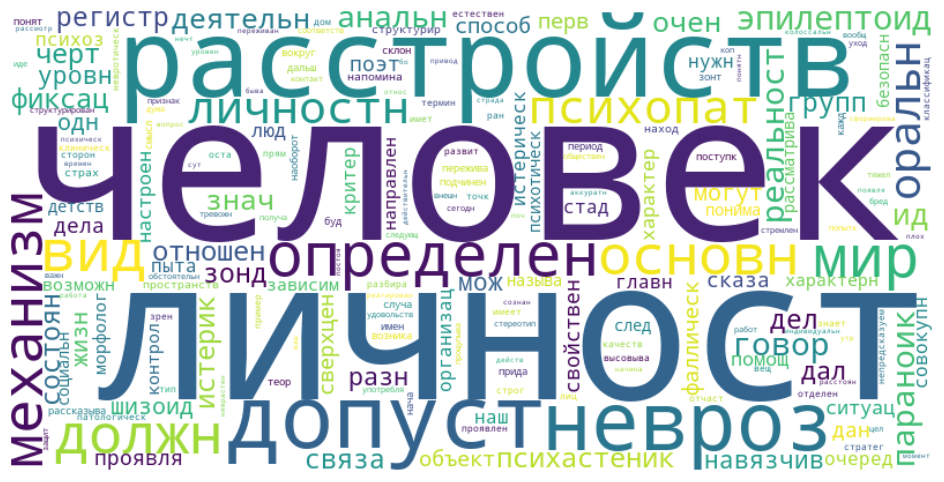

### Топ-20 самых частых стемм

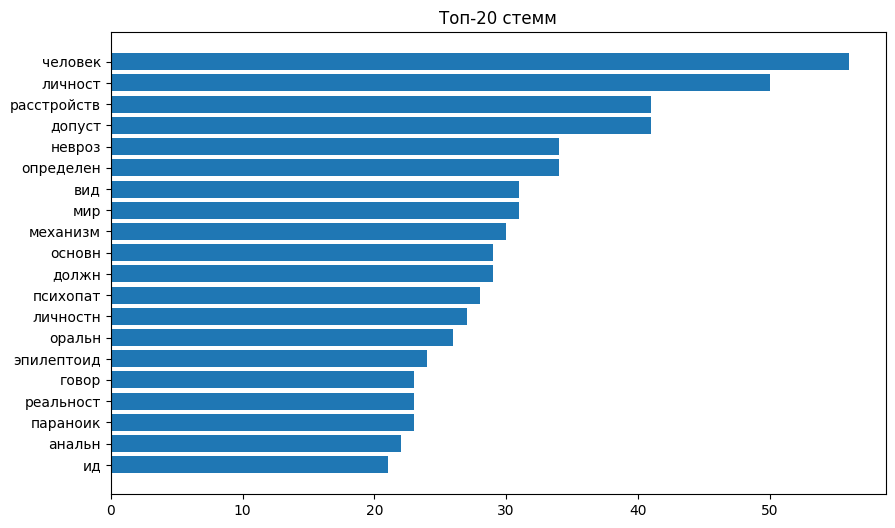

### Распределение частей речи

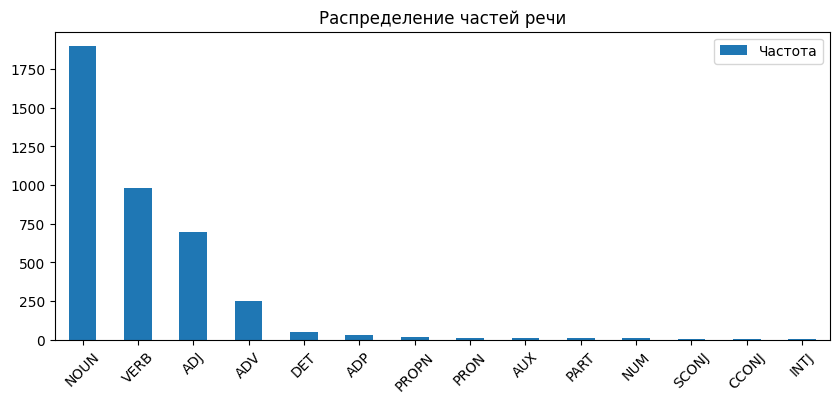

In [8]:
# =========================================
# Визуализации в Jupyter

# 1. Общая статистика
display(Markdown("### Основная статистика текста"))
stats_df = pd.DataFrame({
    "Метрика": ["Предложений", "Токенов (после фильтрации)", "Уникальных стемм", 
                "Type/Token Ratio", "Средняя длина токена", "Средняя длина предложения"],
    "Значение": [len(sentences), num_tokens, num_types, ttr, 
                f"{avg_tok_len:.2f} симв.", f"{avg_sent_len:.2f} слов"]
})
display(stats_df)

# 2. Облако слов
display(Markdown("### Облако слов (основные стеммы)"))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(stem_freq)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# 3. Топ-20 стемм
display(Markdown("### Топ-20 самых частых стемм"))
top_stems = pd.DataFrame(stem_freq.most_common(20), columns=['Стемма', 'Частота'])
plt.figure(figsize=(10, 6))
plt.barh(top_stems['Стемма'], top_stems['Частота'])
plt.gca().invert_yaxis()
plt.title('Топ-20 стемм')
plt.show()

# 4. Распределение частей речи
display(Markdown("### Распределение частей речи"))
pos_df = pd.DataFrame.from_dict(pos_counts, orient='index', columns=['Частота']).sort_values('Частота', ascending=False)
pos_df.plot(kind='bar', figsize=(10, 4))
plt.title('Распределение частей речи')
plt.xticks(rotation=45)
plt.show()

# Сохранение результатов
df_tokens.to_csv('token_analysis.csv', index=False, encoding='utf-8-sig')

stats = {
    'sentences': len(sentences),
    'tokens': num_tokens,
    'unique_stems': num_types,
    'ttr': ttr,
    'avg_token_length': round(avg_tok_len, 2),
    'avg_sentence_length': round(avg_sent_len, 2),
    'top_pos': pos_counts,
    'top_dep': dep_counts,
}

with open('text_statistics.json', 'w', encoding='utf-8') as f:
    json.dump(stats, f, ensure_ascii=False, indent=2)



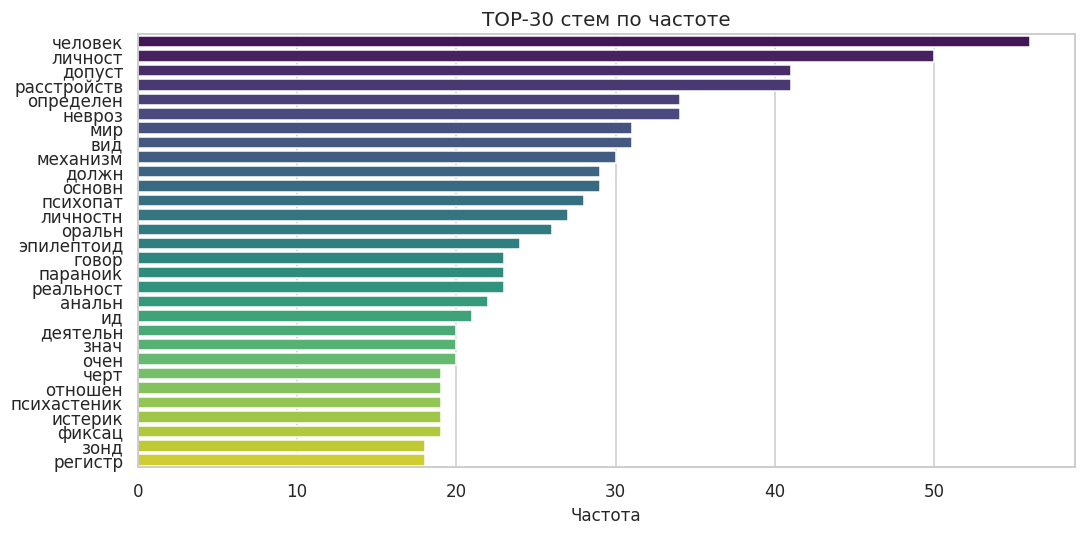

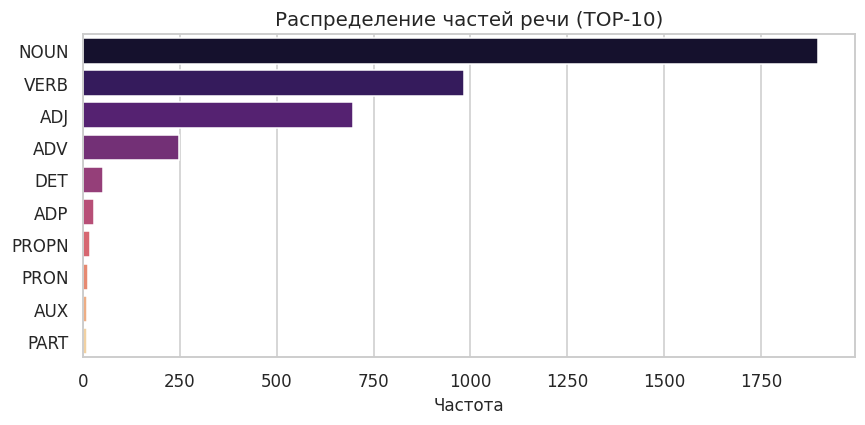

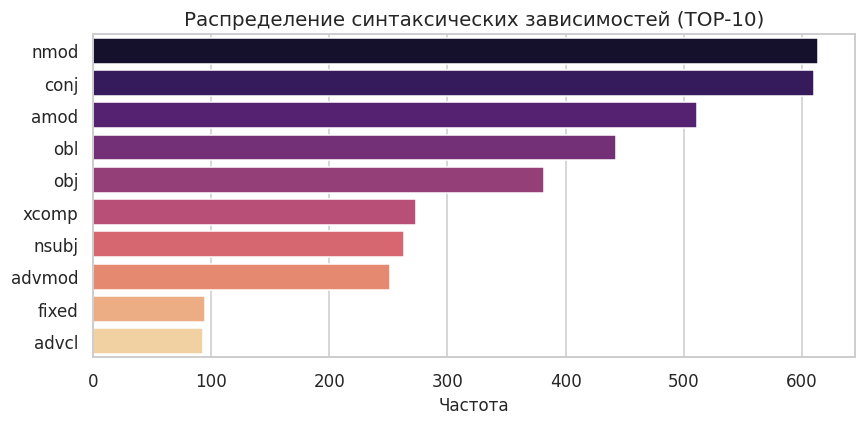

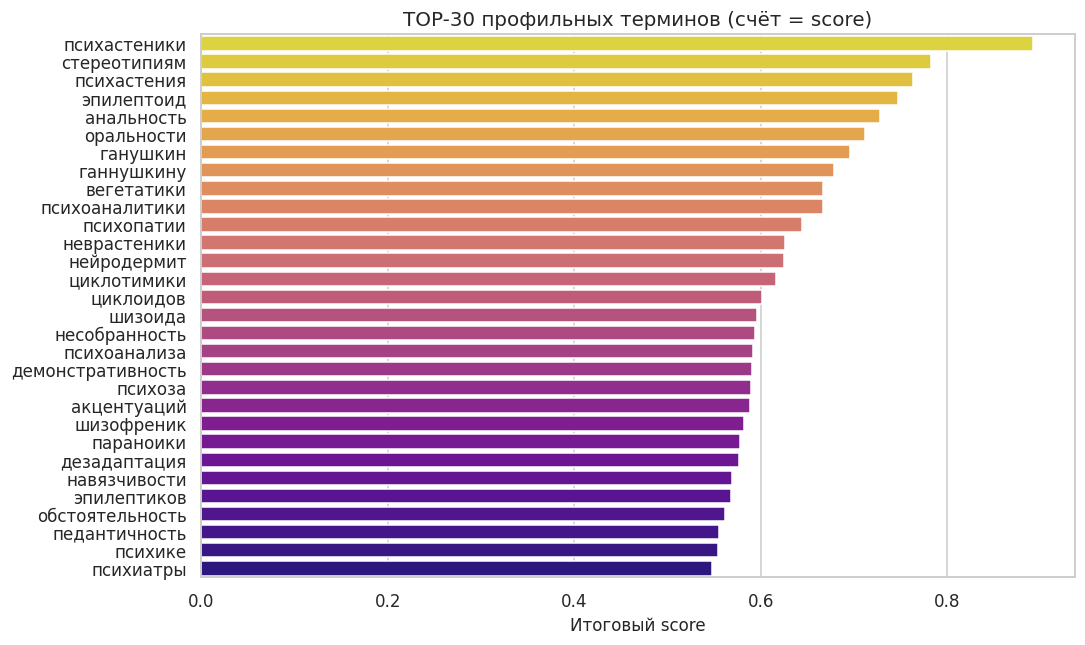

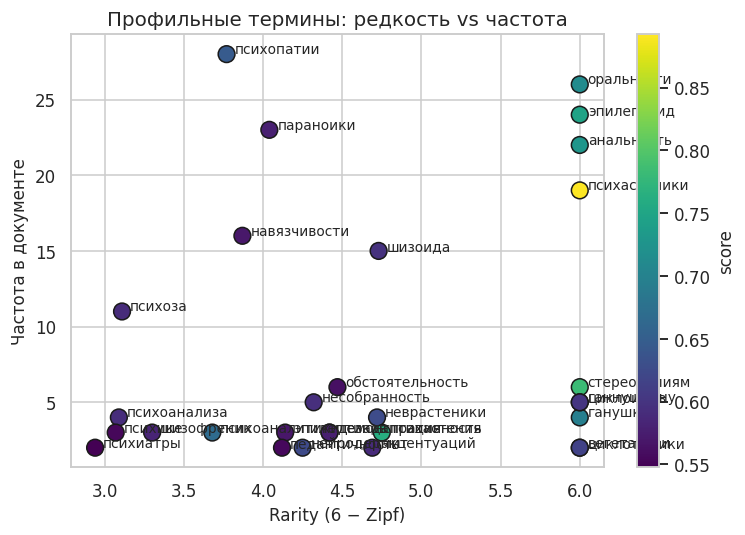

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib.font_manager import FontProperties, findSystemFonts
import os

# Настройка стиля графиков
sns.set(style='whitegrid')
plt.rcParams.update({
    'figure.dpi': 110,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11
})

def pick_cyrillic_font():
    """Выбирает шрифт с поддержкой кириллицы из доступных в системе"""
    for p in findSystemFonts():
        if any(name in p.lower() for name in ('arial', 'dejavu', 'roboto', 'verdana')):
            return FontProperties(fname=p).get_name()
    return None

# Установка шрифта с кириллицей
cy_font = pick_cyrillic_font()
if cy_font:
    plt.rcParams['font.family'] = cy_font

# Проверка наличия df_tokens
if 'df_tokens' not in globals():
    print("❗ DataFrame 'df_tokens' не найден. Создайте его перед выполнением этого кода.")
else:
    # TOP стемов
    top_n_stems = 30
    
    try:
        top_stems = (df_tokens['stem']
                     .value_counts()
                     .head(top_n_stems)
                     .reset_index(name='freq')
                     .rename(columns={'index': 'stem'}))
        
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.barplot(data=top_stems,
                    x='freq',
                    y='stem',
                    hue='stem',  # Добавлено для устранения предупреждения
                    palette='viridis',
                    legend=False,  # Отключаем легенду, так как она избыточна
                    ax=ax)
        ax.set_title(f'TOP-{top_n_stems} стем по частоте')
        ax.set_xlabel('Частота')
        ax.set_ylabel('')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"❗ Ошибка при построении графика стемов: {e}")

    # Части речи (POS)
    try:
        pos_counts = df_tokens['pos'].value_counts().head(10)
        plt.figure(figsize=(8,4))
        sns.barplot(x=pos_counts.values, 
                    y=pos_counts.index, 
                    hue=pos_counts.index,  # Добавлено
                    palette='magma',
                    legend=False)  # Отключаем легенду
        plt.title('Распределение частей речи (TOP-10)')
        plt.xlabel('Частота')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"❗ Ошибка при построении графика частей речи: {e}")

    # Синтаксические зависимости (DEP)
    try:
        dep_counts = df_tokens['dep'].value_counts().head(10)
        plt.figure(figsize=(8,4))
        sns.barplot(x=dep_counts.values, 
                    y=dep_counts.index,
                    hue=dep_counts.index,  # Добавлено
                    palette='magma',
                    legend=False)  # Отключаем легенду
        plt.title('Распределение синтаксических зависимостей (TOP-10)')
        plt.xlabel('Частота')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"❗ Ошибка при построении графика зависимостей: {e}")

# Профильные термины (cands)
if 'cands' in globals() and not cands.empty:
    try:
        top_n_terms = 30
        top_terms = cands.head(top_n_terms)

        plt.figure(figsize=(10,6))
        sns.barplot(data=top_terms,
                    x='score',
                    y='form',
                    hue='form',  # Добавлено
                    palette='plasma_r',
                    legend=False)  # Отключаем легенду
        plt.title(f'TOP-{top_n_terms} профильных терминов (счёт = score)')
        plt.xlabel('Итоговый score')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(7,5))
        sc = plt.scatter(top_terms['rarity'],
                         top_terms['freq'],
                         c=top_terms['score'],
                         cmap='viridis',
                         s=120,
                         edgecolor='k')
        for _, r in top_terms.iterrows():
            plt.text(r.rarity+0.05, r.freq+0.05,
                     r.form, fontsize=9)
        plt.colorbar(sc, label='score')
        plt.title('Профильные термины: редкость vs частота')
        plt.xlabel('Rarity (6 − Zipf)')
        plt.ylabel('Частота в документе')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"❗ Ошибка при построении графиков профильных терминов: {e}")
else:
    print('❗ Профильные термины (DataFrame "cands") отсутствуют либо пусты.')

### Вывод о проделанной работе.
В ходе выполнения курсовой работы мной была разработана комплексная программа для транскрибации и лингвистического анализа аудио/видео материалов. 

##### Успешная реализация:
- Создал работоспособную систему конвертации медиафайлов (MP3, MP4 → WAV)
- Интегрировал модель распознавания речи Vosk/Kaldi
- Реализовал графический интерфейс для удобной работы

##### Инновационные решения:
- Разработал комбинированный алгоритм извлечения ключевых терминов
- Применил многоуровневую систему оценки качества (5 метрик)
- Создал комплекс визуализаций для анализа результатов

##### Практическая ценность:
- Программа автоматизирует процесс расшифровки лекций/интервью
- Генерирует профессиональные лингвистические отчеты
- Формирует терминологические глоссарии для специалистов

##### Работа позволила глубоко освоить современные NLP-технологии и релевантные Python-библиотеки. Разработанная программа демонстрирует практическое применение теоретических знаний в области обработки естественного языка.